In [2]:
import gymnasium as gym
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.logger import configure

from evaluation.evalcallback_feedback import CurriculumEvalCallback

from utils.envs_utils import *


In [3]:
def load_training_log(logger_path, task):
    training_log = np.load(logger_path + "/evaluations.npz", allow_pickle=True)

    reward_task = training_log["results_task"].mean(axis=1)
    task_list = training_log["task"]
    reward_dict = training_log["results_dict"]
    success = training_log["successes"]

    task_indicies = np.where(task_list == task)[0]
    reward_task = reward_task[task_indicies]
    reward_dict = reward_dict[task_indicies]
    # success = success[task_indicies]

    averaged_dicts = []

    for row in reward_dict:
        sum_dict = {}
        for col in row:
            for key in col:
                sum_dict[key] = sum_dict.get(key, 0) + col[key]

        avg_dict = {key: value/len(row) for key, value in sum_dict.items()}
        averaged_dicts.append(avg_dict)

    reward_df = pd.DataFrame(averaged_dicts)

    return reward_task, reward_df, success

In [9]:
logger_path = "./logs/AntMaze_UMaze_SAC/goal_orientation/sample_1"

reward_task, reward_df, success = load_training_log(logger_path, task="goal_orientation")

In [10]:
for key in reward_df.keys():
    print(key)

velocity
orientation_reward


In [11]:
logger_path = "./logs/AntMaze_UMaze_SAC/goal_orientation/sample_2"

reward_task_1, reward_df_1, success_1 = load_training_log(logger_path, task="goal_orientation")

In [12]:
for key in reward_df_1.keys():
    print(key)

velocity
orientation_reward


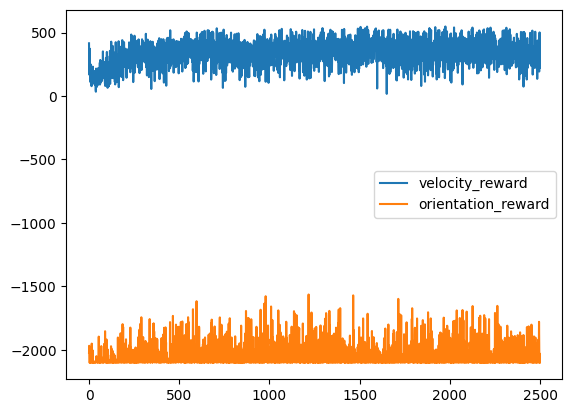

In [22]:
plt.plot(reward_df_1["velocity"], label = "velocity_reward")
plt.plot(reward_df_1["orientation_reward"], label = "orientation_reward")
plt.legend()

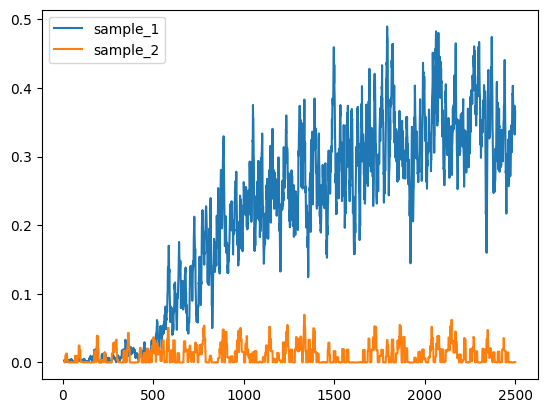

In [13]:
success_moving_avg = pd.Series(success.mean(axis=1)).rolling(10).mean()
success_moving_avg_1 = pd.Series(success_1.mean(axis=1)).rolling(10).mean()
plt.plot(success_moving_avg, label="sample_1")
plt.plot(success_moving_avg_1, label="sample_2")
plt.legend()

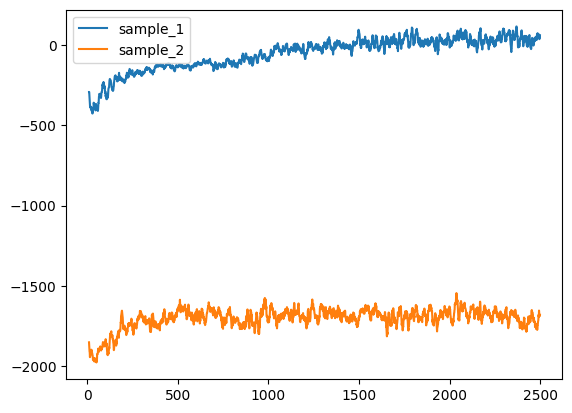

In [19]:
moving_average = pd.Series(reward_task).rolling(window=10).mean()
moving_average_1 = pd.Series(reward_task_1).rolling(window=10).mean()
plt.plot(moving_average, label="sample_1")
plt.plot(moving_average_1, label="sample_2")
plt.legend()

Train goal conditioned policy

In [15]:
env = make_vec_env("Curriculum/AntMaze_UMaze-v0")

/home/kh-ryu/anaconda3/envs/curriculum/lib/python3.10/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment Curriculum/AntMaze_UMaze-v0 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(


In [16]:
obs = env.reset()
print(obs)

# model = SAC.load("./logs/AntMaze_UMaze_SAC/goal_orientation/sample_0/final_model.zip")

# for i in range(100):
#     action, _states = model.predict(obs, deterministic=True)
#     obs, rewards, dones, info = env.step(action)
#     # print(obs['observation'].shape)

OrderedDict([('achieved_goal', array([[-3.73005146, -4.08769301]])), ('desired_goal', array([[ 4.83783171, -3.69448162]])), ('observation', array([[-3.73005146, -4.08769301,  0.75      ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]]))])


In [17]:
goal_pos = obs['desired_goal']
xyz_coord = obs['observation'][0][:3]
print(xyz_coord)
distance= np.linalg.norm(goal_pos - xyz_coord[:2])

distance

[-3.73005146 -4.08769301  0.75      ]


8.57690137909474

In [18]:
rewards

NameError: name 'rewards' is not defined

In [ ]:
model.policy